# Build BUSCO Gene Based Phylogenetic Trees for Alternaria and Relatives

In [1]:
## Import dependencies

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tarfile

In [2]:
## Define primary taxa of interest (the taxa specified in folders/filenames)
#Taxa = "Alternaria"

## Load BUSCOs and Remove Low BUSCO Percentage Assemblies

#### First, load list of Alternaria accessions and identify this subset of BUSCO results zip files

In [3]:
## Load list of fungi assemblies in GenBank, then remove duplicate accessions due to RefSeq
## Also add genus and species columns for filtering

# Change to appropriate directory containing summary of assemblies downloaded from GenBank
os.chdir('/nfs4/BPP/Uehling_Lab/johnsh/FungalLINs/AccessionsForLINs/NCBIDownload_WeekOfOct23_2024')

# Replace 'file.tsv' with your actual file path
fungi_df = pd.read_csv('AllNCBI-FungalGenomes_Oct23_2024.tsv', sep='\t')

# Create a mask for GCF rows
gcf_mask = fungi_df['Assembly Accession'].str.startswith('GCF')

# Create a DataFrame of GCFs
gcf_df = fungi_df[gcf_mask]

# Create a new column in the original DataFrame to indicate presence of GCFs
# Initialize the column with False
fungi_df['Has GCF'] = False

# Set Has GCF to True for the corresponding GCAs
# Assuming GCA accessions correspond directly to GCF accessions by removing the 'GCF_' prefix
for gcf_accession in gcf_df['Assembly Accession']:
    gca_accession = gcf_accession.replace('GCF', 'GCA')  # Modify according to your naming convention
    if gca_accession in fungi_df['Assembly Accession'].values:
        fungi_df.loc[fungi_df['Assembly Accession'] == gca_accession, 'Has GCF'] = True

# Filter out rows where 'Assembly Accession' starts with 'GCF'
fungi_df = fungi_df[~gcf_mask]

# Reset index after deleting rows
fungi_df = fungi_df.reset_index(drop=True)

# Filter out rows where 'Assembly Accession' starts with 'GCF'
fungi_df = fungi_df[~fungi_df['Assembly Accession'].str.startswith('GCF')]

# Reset index after deleting rows
fungi_df = fungi_df.reset_index(drop=True)

# Add the genus column (extracting from Organism Name)
fungi_df['Genus'] = fungi_df['Organism Name'].apply(lambda x: x.split()[0])  # Assuming the genus is the first word
fungi_df['Species'] = fungi_df['Organism Name'].apply(lambda x: x.split()[1])  # Assuming the species is the first word


/scratch/ipykernel_3519899/2830440857.py:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  fungi_df = pd.read_csv('AllNCBI-FungalGenomes_Oct23_2024.tsv', sep='\t')


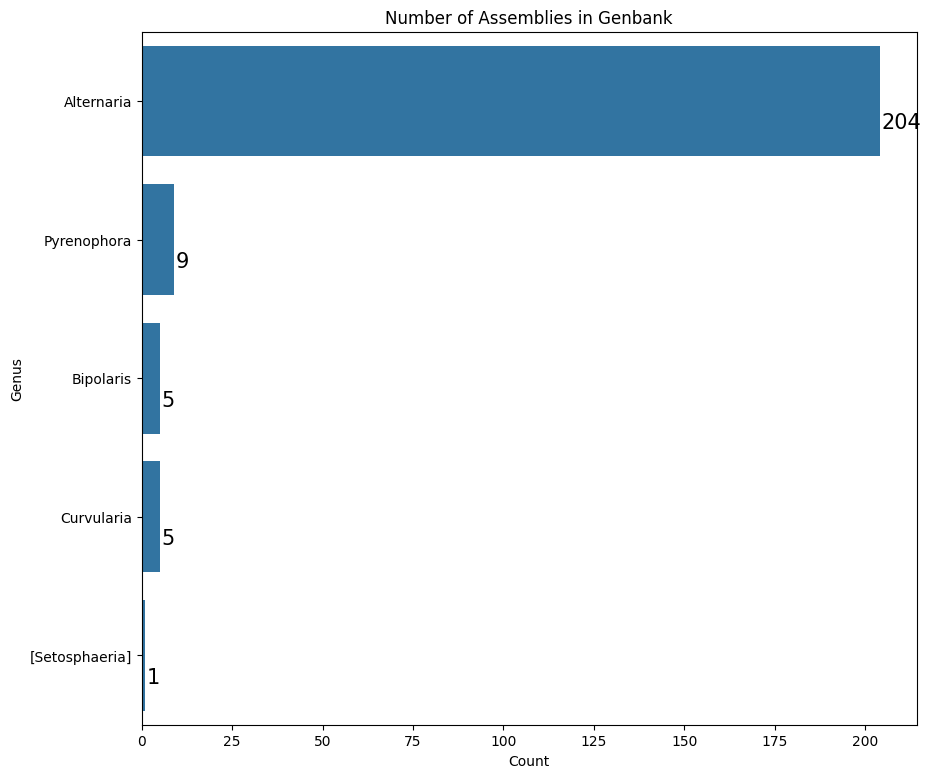

In [4]:
## See how many assemblies there are for a particular genus and related genera (from looking at publications)
## If not enough relatives have assemblies, will need to go to higher taxa

Alternaria = ["Alternaria"]
Setosphaeria = ["[Setosphaeria]"]
Pyrenophora = ["Pyrenophora"]
Bipolaris = ["Bipolaris"]
Curvularia = ["Curvularia"]

# Create a new DataFrame, and create and reduce dataframes for taxa with more assemblies than we should need
Alternaria_df = fungi_df[fungi_df['Genus'].isin(Alternaria)]
Setosphaeria_df = fungi_df[fungi_df['Genus'].isin(Setosphaeria)]
Pyrenophora_df = fungi_df[fungi_df['Genus'].isin(Pyrenophora)]
Bipolaris_df = fungi_df[fungi_df['Genus'].isin(Bipolaris)]
Curvularia_df = fungi_df[fungi_df['Genus'].isin(Curvularia)]
Pyrenophora_df = Pyrenophora_df[:9]
Bipolaris_df = Bipolaris_df[:5]
Curvularia_df = Curvularia_df[:5]

# Combine alternaria with reduced relatives dataframes
Alternaria_df = pd.concat([Alternaria_df, Setosphaeria_df])
Alternaria_df = pd.concat([Alternaria_df, Pyrenophora_df])
Alternaria_df = pd.concat([Alternaria_df, Bipolaris_df])
Alternaria_df = pd.concat([Alternaria_df, Curvularia_df])

# Count the occurrences of each unique genus and create a DataFrame
Genus_counts = Alternaria_df['Genus'].value_counts().reset_index()
Genus_counts.columns = ['Genus', 'Count']  # Rename columns

# Create a horizontal bar chart
plt.figure(figsize=(10, 9))
bar_plot = sns.barplot(x='Count', y='Genus', data=Genus_counts)

# Annotate the bars with counts
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_width())}',  # Text to display
                      (p.get_width() + 0.5, p.get_y() + 0.2 + p.get_height()/2),  # Position
                       fontsize=15, color='black')

plt.xlabel('Count')
plt.ylabel('Genus')
plt.title('Number of Assemblies in Genbank')
plt.show()

In [5]:
## Make list of the zip folders that correspond to selected taxa BUSCO results

# Switch to directory containing zip files of BUSCO results
os.chdir("/nfs4/BPP/Uehling_Lab/johnsh/FungalLINs/ForGeneTrees/Fungal_BUSCOs")

# Extract accessions from zip file folder names for cross-referencing with list of selected Alternaria accessions
AllfungiBUSCOs_ZipFiles = os.listdir(os.getcwd())
AllfungiBUSCOs_ZipAccessions = ["_".join(x.split("_")[0:2]) for x in AllfungiBUSCOs_ZipFiles]

# Make list of Alternaria accessions from dataframe containing Alternaria GenBank information
AlternariaList = list(Alternaria_df["Assembly Accession"])

# Find indices of elements in list of fungi zip files that are also in list of selected taxa
SelectedBUSCOs_ZipAccessionIndices = [i for i, x in enumerate(AllfungiBUSCOs_ZipAccessions) if x in AlternariaList]

# Use indices determined above to extract filenames of selected taxa BUSCO results as new list
SelectedBUSCOs_ZipFiles = [AllfungiBUSCOs_ZipFiles[i] for i in SelectedBUSCOs_ZipAccessionIndices]

In [6]:
## Sanity check that the correct number of zip files are listed

print(len(AlternariaList))
print(len(SelectedBUSCOs_ZipFiles))

224
212


In [7]:
## Second sanity check: see if files look like the correct taxa under consideration

SelectedBUSCOs_ZipFiles

['GCA_022344415.1_ASM2234441v1_genomic.fna.tar.gz',
 'GCA_022609215.1_ASM2260921v1_genomic.fna.tar.gz',
 'GCA_024043175.1_ASM2404317v1_genomic.fna.tar.gz',
 'GCA_001642055.1_Altal1_genomic.fna.tar.gz',
 'GCA_022344765.1_ASM2234476v1_genomic.fna.tar.gz',
 'GCA_022345445.1_ASM2234544v1_genomic.fna.tar.gz',
 'GCA_040583925.1_DAOMC238797_v1_genomic.fna.tar.gz',
 'GCA_023758145.1_ASM2375814v1_genomic.fna.tar.gz',
 'GCA_017589455.1_ASM1758945v1_genomic.fna.tar.gz',
 'GCA_020736745.1_ASM2073674v1_genomic.fna.tar.gz',
 'GCA_022345075.1_ASM2234507v1_genomic.fna.tar.gz',
 'GCA_030704925.1_ASM3070492v1_genomic.fna.tar.gz',
 'GCA_022344355.1_ASM2234435v1_genomic.fna.tar.gz',
 'GCA_040583915.1_DAOMC238806_v1_genomic.fna.tar.gz',
 'GCA_023920165.1_ASM2392016v1_genomic.fna.tar.gz',
 'GCA_024291825.1_ASM2429182v1_genomic.fna.tar.gz',
 'GCA_022345305.1_ASM2234530v1_genomic.fna.tar.gz',
 'GCA_022344695.1_ASM2234469v1_genomic.fna.tar.gz',
 'GCA_023757995.1_ASM2375799v1_genomic.fna.tar.gz',
 'GCA_00965063

In [8]:
## Determine the completeness and single copy number directly from BUSCO results compressed tarfiles

# Path to the tar.gz file
file_path = '/nfs4/BPP/Uehling_Lab/johnsh/FungalLINs/ForGeneTrees/Fungal_BUSCOs/'

# Create lists for containing results of computations
Completeness = []
SingleCopies = []
Duplicates = []
Fragments = []
Missing = []
count = 0     # Initialize counter used in loop

for i in np.arange(len(SelectedBUSCOs_ZipFiles)):
    count += 1     # Count number of files operated on
    
    # Tarfile operations
    with tarfile.open(file_path+SelectedBUSCOs_ZipFiles[i], 'r:gz') as tar:
    
        # Read the contents of the tar file
        fileList = tar.getnames()      # get filenames for content of tar file
        print("Running for file: ", fileList[0], "     File#"+str(count))     # Print for intermittent status update
        member = tar.getmember(fileList[0]+'/short_summary.txt')     # Select file of interest
        file_content = tar.extractfile(member).read()    # Read file
        lines = file_content.decode('utf-8').split('\n')     # Decode from bytes to readable file, and delimit new lines

        # Compute completeness and number of single copy BUSCO genes 
        #(the following delimits by tabs and selects the appropriate numbers from the BUSCO summary text file)
        NumberComplete = int(lines[9].split('\t')[1])
        NumberSingleCopy = int(lines[10].split('\t')[1])
        NumberDuplicate = int(lines[11].split('\t')[1])
        NumberFragment = int(lines[12].split('\t')[1])
        NumberMissing = int(lines[13].split('\t')[1])
        NumberTotal = int(lines[14].split('\t')[1])
        PercentComplete = 100*(NumberComplete/NumberTotal)
        # Append results to appropriate lists
        Completeness.append(PercentComplete)
        SingleCopies.append(NumberSingleCopy)
        Duplicates.append(NumberDuplicate)
        Fragments.append(NumberFragment)
        Missing.append(NumberMissing)

Running for file:  run_GCA_022344415.1_ASM2234441v1_genomic.fna      File#1
Running for file:  run_GCA_022609215.1_ASM2260921v1_genomic.fna      File#2
Running for file:  run_GCA_024043175.1_ASM2404317v1_genomic.fna      File#3
Running for file:  run_GCA_001642055.1_Altal1_genomic.fna      File#4
Running for file:  run_GCA_022344765.1_ASM2234476v1_genomic.fna      File#5
Running for file:  run_GCA_022345445.1_ASM2234544v1_genomic.fna      File#6
Running for file:  run_GCA_040583925.1_DAOMC238797_v1_genomic.fna      File#7
Running for file:  run_GCA_023758145.1_ASM2375814v1_genomic.fna      File#8
Running for file:  run_GCA_017589455.1_ASM1758945v1_genomic.fna      File#9
Running for file:  run_GCA_020736745.1_ASM2073674v1_genomic.fna      File#10
Running for file:  run_GCA_022345075.1_ASM2234507v1_genomic.fna      File#11
Running for file:  run_GCA_030704925.1_ASM3070492v1_genomic.fna      File#12
Running for file:  run_GCA_022344355.1_ASM2234435v1_genomic.fna      File#13
Running for 

In [9]:
## Determine which files have a completeness of greater than 80%

# List comprehenson to return list of indices which have a completeness of 80% or greater
Over80Indices = [ind for ind, comp in enumerate(Completeness) if comp >= 80]
Over80Indices_SCopy = [ind for ind, comp in enumerate(SingleCopies) if comp >= 606]
Under25Indices_Dupl = [ind for ind, comp in enumerate(Duplicates) if comp <= 189]
OverlapIndices = [item for item in Over80Indices if item in Under25Indices_Dupl] ## Check intersection between completeness and duplicate threshold lists


# Use indices determined above to extract filenames of Cryptococcus BUSCO results as new list
Over80Complete = [SelectedBUSCOs_ZipFiles[i] for i in Over80Indices]
Over80SingleCopy = [SelectedBUSCOs_ZipFiles[i] for i in Over80Indices_SCopy]
Under25Duplicate = [SelectedBUSCOs_ZipFiles[i] for i in Under25Indices_Dupl]
Overlap = [SelectedBUSCOs_ZipFiles[i] for i in OverlapIndices]

# Output number of sequences meeting the completeness criterion
print("Number of sequences with greater than 80% completeness: ",len(Over80Complete), " of ", len(SelectedBUSCOs_ZipFiles))
print("Number of sequences with greater than 80% single-copies: ",len(Over80SingleCopy), " of ", len(SelectedBUSCOs_ZipFiles))
print("Number of sequences with less than 25% duplicates: ",len(Under25Duplicate), " of ", len(SelectedBUSCOs_ZipFiles))
print("Number of sequences with greater than 80% completeness with less than 25% duplicates: ",len(Overlap), " of ", len(SelectedBUSCOs_ZipFiles))

Number of sequences with greater than 80% completeness:  211  of  212
Number of sequences with greater than 80% single-copies:  211  of  212
Number of sequences with less than 25% duplicates:  212  of  212
Number of sequences with greater than 80% completeness with less than 25% duplicates:  211  of  212


In [10]:
# This weird renaming is just to not require changing the following code which uses this variable name (even if the naming is inaccurate)
Over80Complete = Overlap

In [11]:
os.chdir('/nfs4/BPP/Uehling_Lab/johnsh/FungalLINs/ForGeneTrees/IntermediateFiles/Alternaria_IF')

# Create a DataFrame
data = {
    'SingleCopies': SingleCopies,
    'Duplicates': Duplicates,
    'Fragments': Fragments,
    'Missing': Missing,
    'Completeness': Completeness,
    'File' : SelectedBUSCOs_ZipFiles
}

df = pd.DataFrame(data)

# Save to a CSV file
output_file = "Alternaria_BUSCO_Results.csv"
df.to_csv(output_file, index=False)

print(f"DataFrame saved to {output_file}")

DataFrame saved to Alternaria_BUSCO_Results.csv


In [12]:
for i in np.arange(len(SingleCopies)):
    print("S:", SingleCopies[i],"; D:", Duplicates[i], "; F:", Fragments[i], "; M:", Missing[i], ";  C:", Completeness[i])

S: 726 ; D: 1 ; F: 2 ; M: 29 ;  C: 95.91029023746702
S: 754 ; D: 0 ; F: 0 ; M: 4 ;  C: 99.47229551451187
S: 754 ; D: 1 ; F: 0 ; M: 3 ;  C: 99.6042216358839
S: 754 ; D: 1 ; F: 0 ; M: 3 ;  C: 99.6042216358839
S: 752 ; D: 1 ; F: 1 ; M: 4 ;  C: 99.34036939313984
S: 732 ; D: 1 ; F: 1 ; M: 24 ;  C: 96.70184696569922
S: 744 ; D: 1 ; F: 0 ; M: 13 ;  C: 98.28496042216359
S: 748 ; D: 1 ; F: 0 ; M: 9 ;  C: 98.81266490765171
S: 746 ; D: 9 ; F: 0 ; M: 3 ;  C: 99.6042216358839
S: 755 ; D: 1 ; F: 0 ; M: 2 ;  C: 99.73614775725594
S: 742 ; D: 1 ; F: 0 ; M: 15 ;  C: 98.02110817941953
S: 694 ; D: 61 ; F: 0 ; M: 3 ;  C: 99.6042216358839
S: 743 ; D: 1 ; F: 2 ; M: 12 ;  C: 98.15303430079155
S: 751 ; D: 0 ; F: 2 ; M: 5 ;  C: 99.07651715039579
S: 749 ; D: 2 ; F: 0 ; M: 7 ;  C: 99.07651715039579
S: 751 ; D: 1 ; F: 0 ; M: 6 ;  C: 99.2084432717678
S: 747 ; D: 1 ; F: 1 ; M: 9 ;  C: 98.68073878627969
S: 753 ; D: 1 ; F: 1 ; M: 3 ;  C: 99.47229551451187
S: 755 ; D: 0 ; F: 0 ; M: 3 ;  C: 99.6042216358839
S: 752 ; D: 

In [14]:
## Unzip and collect the names of all single copy busco .faa files

# Path to the tar.gz files
file_path = '/nfs4/BPP/Uehling_Lab/johnsh/FungalLINs/ForGeneTrees/Fungal_BUSCOs/'

# Create lists for containing results of computations
AAseqFiles = []
count = 0     # Initialize counter used in loop

for i in np.arange(len(Over80Complete)):
    count += 1     # Count number of files operated on
    print(count)
    
    # Open the tar.gz file
    with tarfile.open(file_path+Over80Complete[i], 'r:gz') as tar:
        
        # List the contents of the tar file
        fileList = tar.getnames()

        # List comprehension to keep only files in the appropriate single copy busco folder
        SingleCopyFiles = [file for file in fileList if '/single_copy_busco_sequences/' in file]

        # List comprehension to keep only .faa (amino acid sequence) files
        AAseqFiles.append([file for file in SingleCopyFiles if file.endswith(".faa")])
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211


In [15]:
## Determine the common single copy BUSCOs accross all considered sequences that met the completeness criterion.
## Find the intersection of all faa file lists.

# Make a copy of the list if lists of .faa files for iterating over
AAseqFilesClean = AAseqFiles.copy()

# Remove the initial file/directory information and keep only AA sequence code for all lists
for i in np.arange(len(AAseqFiles)):
    AAseqFilesClean[i] = [x.split("/")[3] for x in AAseqFiles[i]]

# Start with an initial list. Make it a set, then next function will remove non-common elements
FirstFilesFAAfiles = set(AAseqFilesClean[0])  

# Use set intersection to keep only common elements, iterate through all other lists
for sublist in AAseqFilesClean[1:]:
    FirstFilesFAAfiles.intersection_update(sublist)  # Update to keep only common elements

# Convert the set back to a list 
CommonElements = list(FirstFilesFAAfiles)

# Check number of common single copy BUSCOs
print(len(CommonElements))  # Print number of common elements (i.e., the BUSCOs common to all assemblies considered)

240


In [16]:
## Unzip and collect the names of all single copy busco .faa files

# Path to the tar.gz files
file_path = '/nfs4/BPP/Uehling_Lab/johnsh/FungalLINs/ForGeneTrees/Fungal_BUSCOs/'

# Create lists for containing results of computations
AAsequences = []    # Empty list for containing concatenated single copy BUSCO sequences
CommonBUSCO_FileList = []   # Save filenames of common buscos to check later if order is the same for each sample
count = 0     # Initialize counter used in loop

# Loop for reading amino acid sequence files of single copy BUSCOs and combining all common BUSCOs per assembly
for i in np.arange(len(Over80Complete)):
    count += 1     # Count number of files operated on
    CurrentSequence = []
    ForHeader = "_".join(Over80Complete[i].split("_")[0:2])
    print(count)
    
    # Open the tar.gz file
    with tarfile.open(file_path+Over80Complete[i], 'r:gz') as tar:
        
        # List the contents of the tar file
        fileList = tar.getnames()

        # Consider only files within the single copy BUSCO directory
        SingleCopyFiles = [file for file in fileList if '/single_copy_busco_sequences/' in file]

        # List comprehension to keep only files which are from common BUSCOs amongst all selected assemblies 
        CommonBUSCOs = [file for file in SingleCopyFiles if any(common_element in file for common_element in CommonElements)]
        CommonBUSCO_FileList.append(CommonBUSCOs)
        
        # This loop 
        for ii in np.arange(len(CommonBUSCOs)):
            member = tar.getmember(CommonBUSCOs[ii])     # Select file of interest
            file_content = tar.extractfile(member).read()    # Read file
            lines = file_content.decode('utf-8').split('\n')     # Decode from bytes to readable file, and delimit new lines
            AAsequence = ''.join(line for line in lines if not line.startswith('>'))     # Delete headers and join lines
            CurrentSequence.append(AAsequence+"\n")     # Add current amino acid sequence to growing list of amino acid sequences

        # Combine list of amino acid sequences into one overall sequence of all common single copy BUSCOs, and add to list iteratively
        AAsequences.append(">"+ForHeader+"\n"+"".join(ind for ind in CurrentSequence))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211


In [23]:
## Sanity check that the right amount of common elements have been extracted

for i in np.arange(len(Over80Complete)):
    print(len(CommonElements), len(CommonBUSCO_FileList[i]))

240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240


In [19]:
## This is an initial check that elements are in the same order for all lists of common BUSCOs

# Create an empty matrix to store the comparison results
# Initialize with zeros (no mismatch)
matrix = np.zeros((len(CommonBUSCO_FileListEx), len(CommonBUSCO_FileListEx[0])), dtype=int)

# Iterate over all pairs of lists
for i in range(len(CommonBUSCO_FileListEx)):
    for j in range(i + 1, len(CommonBUSCO_FileListEx)):
        # Determine the length to compare
        min_length = min(len(CommonBUSCO_FileListEx[i]), len(CommonBUSCO_FileListEx[j]))
        
        # Compare elements between list i and list j up to the shortest length
        for k in range(min_length):
            if CommonBUSCO_FileListEx[i][k] != CommonBUSCO_FileListEx[j][k]:
                # Mark the mismatch in both rows for the specific column (k)
                matrix[i, k] = 1
                matrix[j, k] = 1

# Now matrix holds 0s and 1s indicating whether each column has mismatches (1 means mismatch)

# Check if all elements are in the same order
if np.all(matrix == 0):
    print("All elements are in the same order across all lists.")
else:
    print("Some elements are out of order across lists.")

All elements are in the same order across all lists.


In [18]:
## This is the more fine-grained approach to check order among lists of common BUSCOs

CommonBUSCO_FileListEx = [ [path.split("/")[-1] for path in CommonBUSCO_FileList[i]] for i in range(len(CommonBUSCO_FileList)) ]

for i in np.arange(len(CommonBUSCO_FileListEx)):
    for ii in np.arange(len(Over80Complete)):
        print(CommonBUSCO_FileListEx[ii][i], str(ii))

451849at4751.faa 0
451849at4751.faa 1
451849at4751.faa 2
451849at4751.faa 3
451849at4751.faa 4
451849at4751.faa 5
451849at4751.faa 6
451849at4751.faa 7
451849at4751.faa 8
451849at4751.faa 9
451849at4751.faa 10
451849at4751.faa 11
451849at4751.faa 12
451849at4751.faa 13
451849at4751.faa 14
451849at4751.faa 15
451849at4751.faa 16
451849at4751.faa 17
451849at4751.faa 18
451849at4751.faa 19
451849at4751.faa 20
451849at4751.faa 21
451849at4751.faa 22
451849at4751.faa 23
451849at4751.faa 24
451849at4751.faa 25
451849at4751.faa 26
451849at4751.faa 27
451849at4751.faa 28
451849at4751.faa 29
451849at4751.faa 30
451849at4751.faa 31
451849at4751.faa 32
451849at4751.faa 33
451849at4751.faa 34
451849at4751.faa 35
451849at4751.faa 36
451849at4751.faa 37
451849at4751.faa 38
451849at4751.faa 39
451849at4751.faa 40
451849at4751.faa 41
451849at4751.faa 42
451849at4751.faa 43
451849at4751.faa 44
451849at4751.faa 45
451849at4751.faa 46
451849at4751.faa 47
451849at4751.faa 48
451849at4751.faa 49
451849at47

In [18]:
## Save extracted common single copy BUSCOs for all species as a single .fna file

# Make and move to folder for storing concatenated BUSCOs
os.mkdir('/nfs4/BPP/Uehling_Lab/johnsh/FungalLINs/ForGeneTrees/IntermediateFiles/Alternaria_IF')
os.chdir('/nfs4/BPP/Uehling_Lab/johnsh/FungalLINs/ForGeneTrees/IntermediateFiles/Alternaria_IF')

# Open a file to write the sequences to a .faa file
with open("AlternariaBUSCOsForAlignment.faa", "w") as f:
    for sequence in AAsequences:
        # Write the sequence directly to the file
        f.write(sequence)

In [13]:
os.chdir('/nfs4/BPP/Uehling_Lab/johnsh/FungalLINs/ForGeneTrees/IntermediateFiles/Alternaria_IF')

# Save this variable as it is used again later, don't want to have to rerun code to obtain variable
with open("Alternaria_Over80Complete.txt", "w") as file:
    for item in Over80Complete:
        file.write(item + "\n")

## At this point, from command line perform sequence alignment, remove poor alignment, and build BUSCO tree (i.e., run mafft, TrimAl, and IQ-Tree2 from the command line)

In [14]:
os.chdir('/nfs4/BPP/Uehling_Lab/johnsh/FungalLINs/ForGeneTrees/IntermediateFiles/Alternaria_IF')
with open("Alternaria_Over80Complete.txt", "r") as file:
    Over80Complete = [line.strip() for line in file]

In [15]:
Over80Complete

['GCA_022344415.1_ASM2234441v1_genomic.fna.tar.gz',
 'GCA_022609215.1_ASM2260921v1_genomic.fna.tar.gz',
 'GCA_024043175.1_ASM2404317v1_genomic.fna.tar.gz',
 'GCA_001642055.1_Altal1_genomic.fna.tar.gz',
 'GCA_022344765.1_ASM2234476v1_genomic.fna.tar.gz',
 'GCA_022345445.1_ASM2234544v1_genomic.fna.tar.gz',
 'GCA_040583925.1_DAOMC238797_v1_genomic.fna.tar.gz',
 'GCA_023758145.1_ASM2375814v1_genomic.fna.tar.gz',
 'GCA_017589455.1_ASM1758945v1_genomic.fna.tar.gz',
 'GCA_020736745.1_ASM2073674v1_genomic.fna.tar.gz',
 'GCA_022345075.1_ASM2234507v1_genomic.fna.tar.gz',
 'GCA_030704925.1_ASM3070492v1_genomic.fna.tar.gz',
 'GCA_022344355.1_ASM2234435v1_genomic.fna.tar.gz',
 'GCA_040583915.1_DAOMC238806_v1_genomic.fna.tar.gz',
 'GCA_023920165.1_ASM2392016v1_genomic.fna.tar.gz',
 'GCA_024291825.1_ASM2429182v1_genomic.fna.tar.gz',
 'GCA_022345305.1_ASM2234530v1_genomic.fna.tar.gz',
 'GCA_022344695.1_ASM2234469v1_genomic.fna.tar.gz',
 'GCA_023757995.1_ASM2375799v1_genomic.fna.tar.gz',
 'GCA_00965063

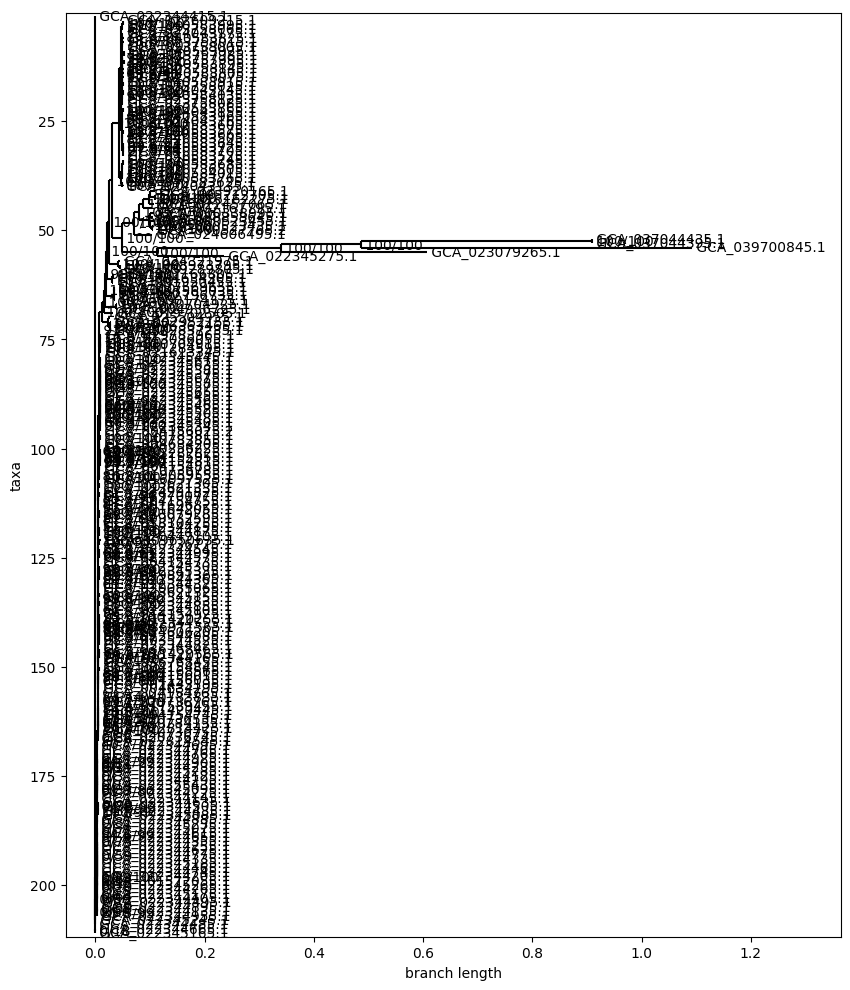

In [16]:
## Display maximum likelihood tree determined using IQtree2


from Bio import Phylo

os.chdir('/nfs4/BPP/Uehling_Lab/johnsh/FungalLINs/ForGeneTrees/IntermediateFiles/Alternaria_IF')


# Load the IQ-TREE output file (convert to Newick format if necessary)
tree = Phylo.read("AlternariaBUSCOsTrimmed.faa.treefile", "newick")

# Plot the tree
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=ax)
plt.show()

In [17]:
'''

## Convert to a rooted tree

# Assuming 'tree' is your unrooted tree
outgroup = ["Outgroup1 Accession", "Outgroup2 Accession"]  

# Root the tree using the specified outgroup
tree.root_with_outgroup(outgroup)

# Now you can plot the rooted tree
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=ax)
plt.show()

'''

'\n\n## Convert to a rooted tree\n\n# Assuming \'tree\' is your unrooted tree\noutgroup = ["Outgroup1 Accession", "Outgroup2 Accession"]  \n\n# Root the tree using the specified outgroup\ntree.root_with_outgroup(outgroup)\n\n# Now you can plot the rooted tree\nfig = plt.figure(figsize=(10, 5))\nax = fig.add_subplot(1, 1, 1)\nPhylo.draw(tree, axes=ax)\nplt.show()\n\n'

In [18]:
Over80Accessions = ["_".join(Over80Complete[i].split("_")[0:2]) for i in np.arange(len(Over80Complete))]

Over80Accessions

['GCA_022344415.1',
 'GCA_022609215.1',
 'GCA_024043175.1',
 'GCA_001642055.1',
 'GCA_022344765.1',
 'GCA_022345445.1',
 'GCA_040583925.1',
 'GCA_023758145.1',
 'GCA_017589455.1',
 'GCA_020736745.1',
 'GCA_022345075.1',
 'GCA_030704925.1',
 'GCA_022344355.1',
 'GCA_040583915.1',
 'GCA_023920165.1',
 'GCA_024291825.1',
 'GCA_022345305.1',
 'GCA_022344695.1',
 'GCA_023757995.1',
 'GCA_009650635.1',
 'GCA_907166805.1',
 'GCA_004936725.1',
 'GCA_001572055.1',
 'GCA_040583865.1',
 'GCA_023621325.1',
 'GCA_004154845.1',
 'GCA_022345185.1',
 'GCA_040583805.1',
 'GCA_022345635.1',
 'GCA_040783815.1',
 'GCA_022344665.1',
 'GCA_022344255.1',
 'GCA_022345175.1',
 'GCA_029783965.1',
 'GCA_022344125.1',
 'GCA_040583575.1',
 'GCA_022344545.1',
 'GCA_022344635.1',
 'GCA_019059555.1',
 'GCA_023758015.1',
 'GCA_004634205.1',
 'GCA_027569655.1',
 'GCA_022344205.1',
 'GCA_022345085.1',
 'GCA_039700775.1',
 'GCA_037044435.1',
 'GCA_025504955.1',
 'GCA_040583895.1',
 'GCA_022344615.1',
 'GCA_004156015.1',


In [19]:
## Create a dictionary which related accession numbers to organism names

# Dictionary comprehension to extract appropriate information
Alternaria_AccessionToSpecies = {
    accession: Alternaria_df.loc[Alternaria_df['Assembly Accession'] == accession, 'Organism Name'].values[0]
    for accession in Over80Accessions
    if accession in Alternaria_df['Assembly Accession'].values
}

# Display the resulting dictionary
print(Alternaria_AccessionToSpecies)

{'GCA_022344415.1': 'Alternaria alternata', 'GCA_022609215.1': 'Alternaria triticina', 'GCA_024043175.1': 'Alternaria infectoria', 'GCA_001642055.1': 'Alternaria alternata', 'GCA_022344765.1': 'Alternaria alternata', 'GCA_022345445.1': 'Alternaria gaisen', 'GCA_040583925.1': 'Alternaria ethzedia', 'GCA_023758145.1': 'Alternaria sp. BMP 2799', 'GCA_017589455.1': 'Alternaria tenuissima', 'GCA_020736745.1': 'Alternaria alternata', 'GCA_022345075.1': 'Alternaria alternata', 'GCA_030704925.1': 'Alternaria brassicae', 'GCA_022344355.1': 'Alternaria alternata', 'GCA_040583915.1': 'Alternaria triticimaculans', 'GCA_023920165.1': 'Curvularia clavata', 'GCA_024291825.1': 'Alternaria postmessia', 'GCA_022345305.1': 'Alternaria alternata', 'GCA_022344695.1': 'Alternaria alternata', 'GCA_023757995.1': 'Alternaria metachromatica', 'GCA_009650635.1': 'Alternaria alternata', 'GCA_907166805.1': 'Alternaria atra', 'GCA_004936725.1': 'Alternaria brassicae', 'GCA_001572055.1': 'Alternaria alternata', 'GCA

In [20]:
# Dictionary comprehension to extract and format organism names with accessions
Alternaria_AccessionToSpecies = {
    accession: f"{Alternaria_df.loc[Alternaria_df['Assembly Accession'] == accession, 'Organism Name'].values[0]} ({accession})"
    for accession in Over80Accessions
    if accession in Alternaria_df['Assembly Accession'].values
}

# Display the resulting dictionary
print(Alternaria_AccessionToSpecies)

{'GCA_022344415.1': 'Alternaria alternata (GCA_022344415.1)', 'GCA_022609215.1': 'Alternaria triticina (GCA_022609215.1)', 'GCA_024043175.1': 'Alternaria infectoria (GCA_024043175.1)', 'GCA_001642055.1': 'Alternaria alternata (GCA_001642055.1)', 'GCA_022344765.1': 'Alternaria alternata (GCA_022344765.1)', 'GCA_022345445.1': 'Alternaria gaisen (GCA_022345445.1)', 'GCA_040583925.1': 'Alternaria ethzedia (GCA_040583925.1)', 'GCA_023758145.1': 'Alternaria sp. BMP 2799 (GCA_023758145.1)', 'GCA_017589455.1': 'Alternaria tenuissima (GCA_017589455.1)', 'GCA_020736745.1': 'Alternaria alternata (GCA_020736745.1)', 'GCA_022345075.1': 'Alternaria alternata (GCA_022345075.1)', 'GCA_030704925.1': 'Alternaria brassicae (GCA_030704925.1)', 'GCA_022344355.1': 'Alternaria alternata (GCA_022344355.1)', 'GCA_040583915.1': 'Alternaria triticimaculans (GCA_040583915.1)', 'GCA_023920165.1': 'Curvularia clavata (GCA_023920165.1)', 'GCA_024291825.1': 'Alternaria postmessia (GCA_024291825.1)', 'GCA_022345305.1'

In [21]:
## Save the dictionary of labels for reuse later

import pickle

# Save dictionary to a file
with open('AlternariaDictionary.pkl', 'wb') as file:
    pickle.dump(Alternaria_AccessionToSpecies, file)

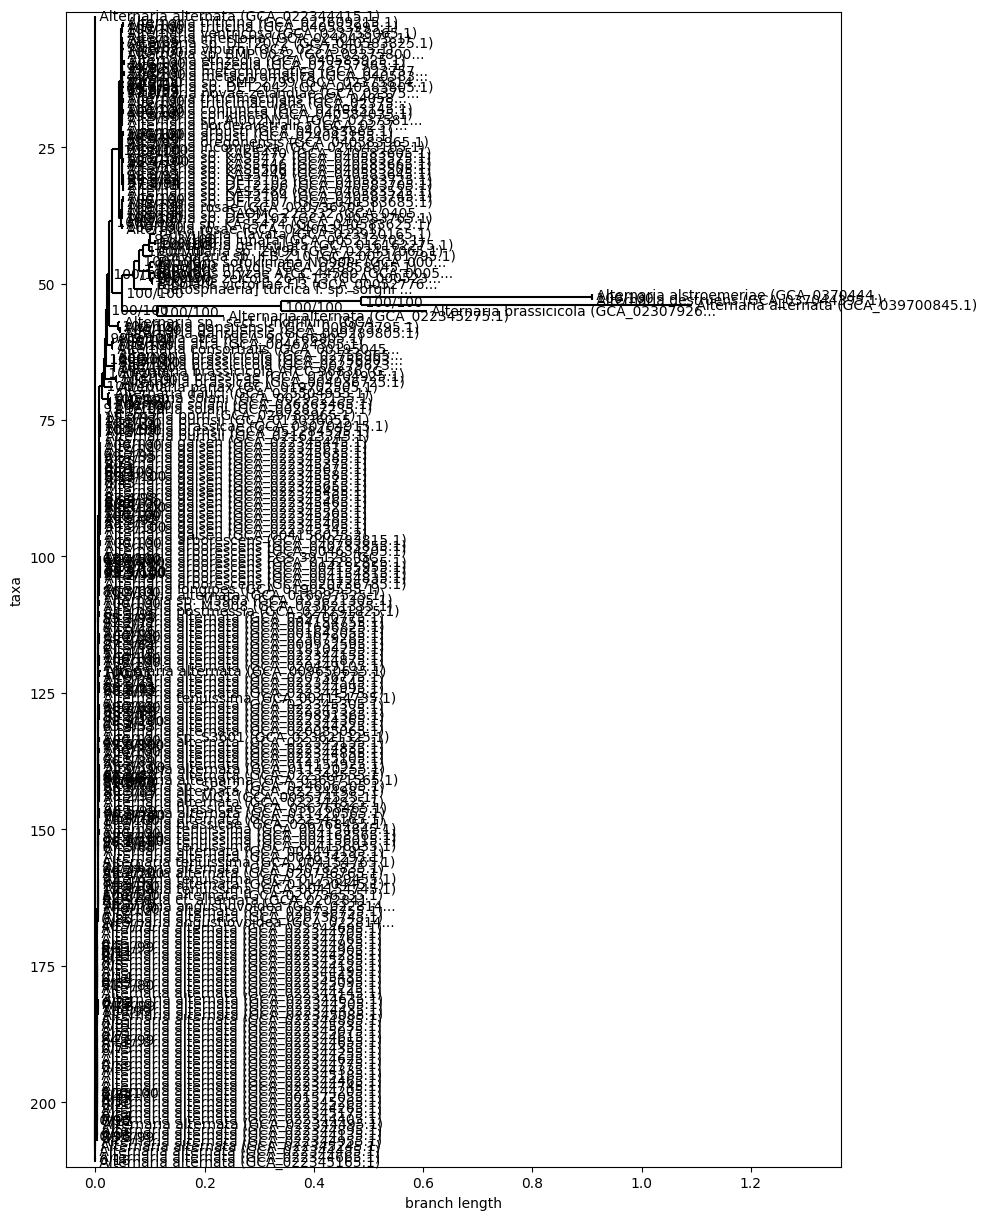

In [22]:
# Load the IQ-TREE output file (Newick format)
tree = Phylo.read("AlternariaBUSCOsTrimmed.faa.treefile", "newick")

# Update the leaf labels in the tree
for leaf in tree.get_terminals():
    if leaf.name in Alternaria_AccessionToSpecies:
        leaf.name = Alternaria_AccessionToSpecies[leaf.name]

# Plot the updated tree
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=ax)
plt.show()